<a href="https://colab.research.google.com/github/JosiahBeynon/detect-pneumonia-xray/blob/main/Detect_Pneumonia_Using_X_Ray_Images_with_CNNs_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning

In this project, I'm experimenting with CV classifiers to demonstrate the affect of varying layers, with a hypothetical aim to build an accurate pnemonia detector.

According to the [World Health Organization](https://www.who.int/health-topics/pneumonia#tab=tab_1):

> Pneumonia is a form of acute respiratory infection that is most commonly caused by viruses or bacteria. It can cause mild to life-threatening illness in people of all ages, however it is the single largest infectious cause of death in children worldwide.
>
>Pneumonia killed more than 808 000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years.  People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems.


Before I get started, let's import the necessary libraries.

In [1]:
import os
import tarfile
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model, Input, applications, initializers
# from tensorflow.keras.utils import count_params
# from tfm.core.train_utils import try_count_params
import tensorflow.keras.backend as K




# Preparing the Data Set

First, I need to download the dataset.

In [2]:
import os
import tarfile

# Define the file URL and local file path
file_url = 'https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz'
local_file_path = 'xray_dataset.tar.gz'

# Define the expected directory or file that would exist after extraction
extracted_path = '/content/chest_xray/train/PNEUMONIA'  # Change this to an actual file or folder name

# Check if the file already exists
if not os.path.exists(local_file_path):
    !wget {file_url} -O {local_file_path}
else:
    print(f"File already exists at {local_file_path}")

# Check if the file has already been extracted
if not os.path.exists(extracted_path):
    if os.path.exists(local_file_path):
        with tarfile.open(local_file_path, 'r:gz') as tar:
            tar.extractall(path='./')
    else:
        print(f"Cannot extract as {local_file_path} does not exist.")
else:
    print(f"File already extracted to {extracted_path}")


File already exists at xray_dataset.tar.gz
File already extracted to /content/chest_xray/train/PNEUMONIA


Now that's downloaded and extracted, let's load the dataset. It only comes with train and test splits, so I'll create a validation set as well.

In [ ]:
# Define the image size and batch size
img_size = (256, 256)
batch_size = 32

# Define the directory paths
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Create the train_set dataset
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.25,
    subset="training",
    seed=417
)

# Create the validation_set dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.25,
    subset="validation",
    seed=417
)

# Create the test_set dataset
test_set = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size
)


Let's check our labels have come out as expected.

In [ ]:
train_set.class_names

Class labels look good, and are obviously named.

Next, I'll plot comparative images from the dataset to get an idea what we're classifying.

## Plotting X-Ray Images

In [ ]:
# Retrieve the images and labels from train_set.take(1)
images, labels = next(iter(train_set.take(1)))

# Convert the images and labels to NumPy arrays
images = images.numpy()
labels = labels.numpy()

# Sort the image-label pairs based on the label (ascending order)
sorted_pairs = sorted(zip(images, labels), key=lambda x: x[1])

# Select a sample of images with both normal and pneumonia labels
sample = sorted_pairs[:4] + sorted_pairs[-4:]

# Plot the sorted images with their corresponding labels
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()

# Format the plot
for i, (image, label) in enumerate(sample):
    axes[i].imshow(image.astype("uint8"))
    axes[i].set_title(train_set.class_names[int(label)])
    axes[i].axis("off")
plt.tight_layout()

# Display the plot
plt.show()
print(f'\nEach image shape is {sample[0][0].shape}')

In [ ]:
# Removes no longer needed variables
del images, labels, sorted_pairs, sample

Would you have guessed those labels from the X-rays? I have no radiography training and find it hard to tell the difference in many cases. The pneumonia X-rays seem to be 'cloudier' than the normal X-rays. But I wouldn't want to be the one diagnosing.

A few things to note:
* The images have 3 channels, despite seeming to be grayscale.
* All X-rays have the right side of the patient (the white 'R' on the image) on the LEFT side of the image. This appears to be consistent across the data set. Given that humans aren't perfectly symmetrical (e.g. our heart is on our left side), we'll not flip any images horizontally. This will preserve the 'sidedness' of the X-rays in case that affects the diagnosis.
* There's a small amount of rotation in the X-rays. Presumably, this is incurred when they take them. We could profit from this by adding rotational augmentation to our training set, which will increase variance without losing 'sidedness'.
* All X--rays picture the same anotomical area. Therefore augmentation tools like `RandomZoom` are unlikely to helpful.
* Brightness and contrast also seem to be stable across the X-rays. Therefore we'll not bother with `RandomBrightness` or `RandomContrast`.

Judging by the similarities between the images, we'll may not get good results with a simple CNN. We'll have a go anyway, and use that as our benchmark.

# Model Building

Before I begin, I'll define a range of helper functions we'll use throughout our modelling.

## Helper Functions

These functions handle the majority of the heavy lifting, allowing me to run and compare models with only a couple lines of code.

# Remove model name as arg if no longer needed

In [ ]:
def plot_history(model):
    ''' Plots the training and validation accuracy and loss for each epoch '''
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for metric, ax in zip(['accuracy', 'loss'], axs):
        ax.plot(np.arange(1, # Corrects epoch number
                          len(model.history[metric]) + 1),
                          model.history[metric])
        ax.plot(np.arange(1, # Corrects epoch number
                          len(model.history['val_' + metric]) + 1),
                          model.history['val_' + metric])
        ax.set_title('Model ' + metric.capitalize())
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


def convert_time(seconds):
    ''' Converts seconds to minutes and seconds and returns as a
    pretty printed string '''
    minutes, seconds = divmod(seconds, 60)
    return f"{round(minutes)} minutes {round(seconds)} seconds"

# Defines EarlyStopping callback we'll use throughout our modelling
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Initializes the metrics list
model_info = []
model_list = []

def fit_plot_store(model_name, model, epochs=10, shuffle=False, batch_size=32):
    ''' Plots the training and validation accuracy and loss for each epoch
    and stores the model as a nested list'''

    # Fitting the model (with timing)
    start = time.time()
    run = model.fit(train_set,
                    epochs=epochs,
                    validation_data=validation_set,
                    shuffle=False,
                    batch_size=batch_size,
                    callbacks=[callback]
                    )
    end = time.time()
    plot_history(run)
    time_to_run = end - start
    print(f'\nIt took {convert_time(time_to_run)} seconds to train the model.')

    # Getting the metrics
    training_accuracy = run.history['accuracy'][-1]
    val_accuracy = run.history['val_accuracy'][-1]
    training_loss = run.history['loss'][-1]
    val_loss = run.history['val_loss'][-1]
    # trainable_params = count_params(model.trainable_weights)
    # non_trainable_params = count_params(model.non_trainable_weights)
    trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    num_epochs = len(run.history['accuracy'])
    total_params = trainable_params + non_trainable_params

    # Store model metrics
    model_info.append([model.name, training_accuracy, val_accuracy,
                       training_loss, val_loss, trainable_params,
                       non_trainable_params, total_params,
                       num_epochs, time_to_run]
                      )
    model_list.append(model)


## Initial CNN - Model 1

I'll start with a fairly small model. We'll use a normalization layer (to rescale the pixel values between 0 and 1), a one convolutional layer, one max pooling, and two dense layers.

In [ ]:
model_1 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_1'
    )

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_1.summary()

Our simple model still has over a million parameters. Though these are almost all in the dense layers. Let's see how our model performs, though I'm not expecting much.

I'll also define a couple helper functions that we'll use throughout our comparisons.

In [ ]:
fit_plot_store('Model 1', model_1)

Our simple model achieved a reasonable 75% accuracy. That's far better than random, yet we wouldn't want to be diagnosed by it yet.

Let's add a few more layers.

## Model 2

We'll add another convolutional layer, a max pooling layer, and a dense layer.

In [ ]:
model_2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_2'
    )

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_2.summary()

We've added two layers and **reduced** the number of parameters by 4X. This is due to our max pooling layers regularizing affect. Let's see how our new model performs.

In [ ]:
fit_plot_store('Model 2', model_2)

Our accuracy has improved significantly to around 96% accuracy.

The model may be beginnining to overfit. Certainly accuracy is starting to level off.

Since we're more interested in comparing general architectures, I'll move on for now and experiment with augmentation.



# Model 3

We're going to try two approaches:
* Rotation - Adding up to 15 degrees of random rotation to some images
* Shuffle - This shuffles the order of the images, stopping the model just learning the order

In [12]:
model_3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(15),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_3'
    )

model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 8)        

Epoch 1/20
123/123 [==============================] - 37s 276ms/step - loss: 0.4904 - accuracy: 0.7390 - val_loss: 0.3008 - val_accuracy: 0.7492
Epoch 2/20
123/123 [==============================] - 38s 291ms/step - loss: 0.3573 - accuracy: 0.8499 - val_loss: 0.3163 - val_accuracy: 0.8769
Epoch 3/20
123/123 [==============================] - 37s 288ms/step - loss: 0.3425 - accuracy: 0.8568 - val_loss: 0.3285 - val_accuracy: 0.8853
Epoch 4/20
123/123 [==============================] - 35s 275ms/step - loss: 0.3090 - accuracy: 0.8853 - val_loss: 0.2783 - val_accuracy: 0.8968
Epoch 5/20
123/123 [==============================] - 35s 275ms/step - loss: 0.2980 - accuracy: 0.8853 - val_loss: 0.2557 - val_accuracy: 0.9205
Epoch 6/20
123/123 [==============================] - 37s 287ms/step - loss: 0.2819 - accuracy: 0.8960 - val_loss: 0.2436 - val_accuracy: 0.9182
Epoch 7/20
123/123 [==============================] - 34s 263ms/step - loss: 0.2850 - accuracy: 0.8891 - val_loss: 0.2298 - val_ac

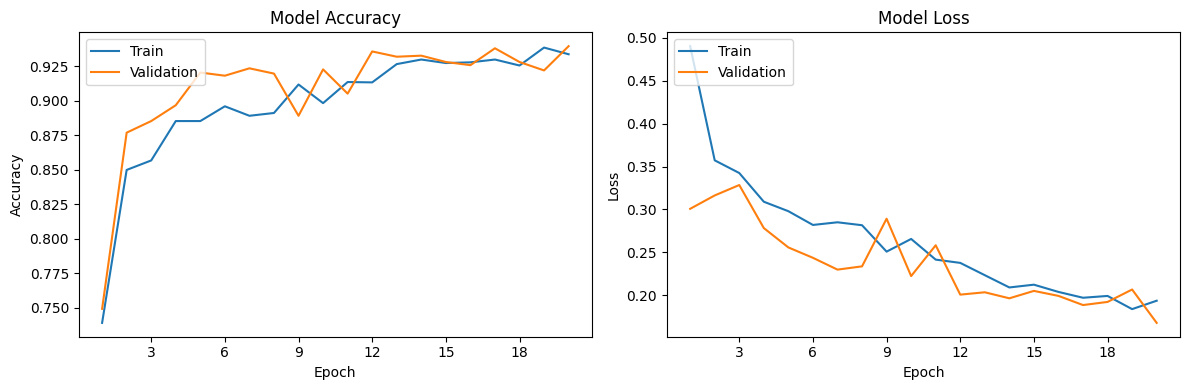


It took 12 minutes 25 seconds seconds to train the model.


In [13]:
fit_plot_store('Model 3', model_3, epochs=20, shuffle=True)

Adding shuffle and rotate didn't help. In fact. it reduced the accuracy.

It seems our simple model wasn't able to cope with the added complexity, so lets try a more complex model.

## Model 4

In [ ]:
model_4 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(15),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_4'
    )

model_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)     

We'e

Epoch 1/20
123/123 [==============================] - 49s 337ms/step - loss: 0.5123 - accuracy: 0.7449 - val_loss: 0.4151 - val_accuracy: 0.7737
Epoch 2/20
123/123 [==============================] - 40s 316ms/step - loss: 0.3816 - accuracy: 0.8221 - val_loss: 0.3833 - val_accuracy: 0.7752
Epoch 3/20
123/123 [==============================] - 38s 299ms/step - loss: 0.3571 - accuracy: 0.8428 - val_loss: 0.3114 - val_accuracy: 0.8830
Epoch 4/20
123/123 [==============================] - 39s 303ms/step - loss: 0.3267 - accuracy: 0.8835 - val_loss: 0.3625 - val_accuracy: 0.8723
Epoch 5/20
123/123 [==============================] - 39s 298ms/step - loss: 0.3045 - accuracy: 0.8996 - val_loss: 0.2717 - val_accuracy: 0.9128
Epoch 6/20
123/123 [==============================] - 40s 308ms/step - loss: 0.2852 - accuracy: 0.9021 - val_loss: 0.2674 - val_accuracy: 0.9083
Epoch 7/20
123/123 [==============================] - 40s 316ms/step - loss: 0.2794 - accuracy: 0.9044 - val_loss: 0.2725 - val_ac

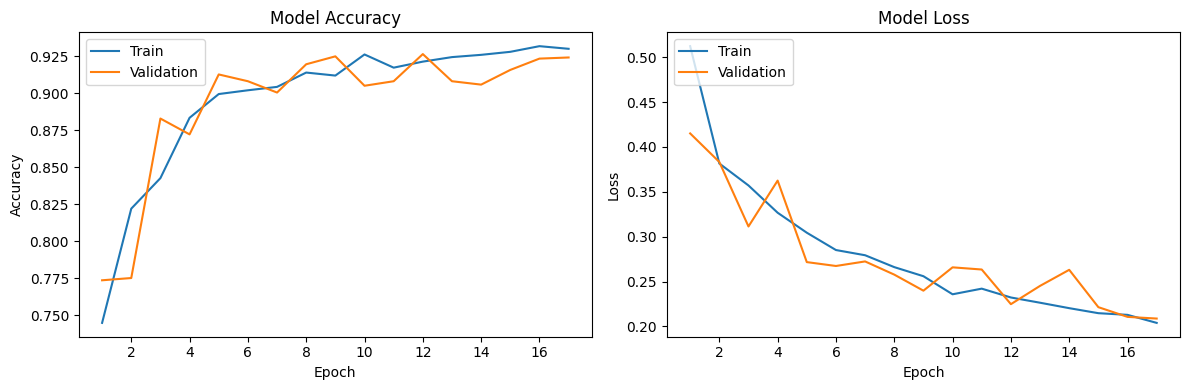


It took 11 minutes 33 seconds seconds to train the model.


In [ ]:
fit_plot_store('Model 4', model_4, epochs=20, shuffle=True)

This performed better than model 3, and is still lagging behind model 2.

As you can see above, the process of tuning a model is long and experimental. We could keep tweaking models. However, in many cases it's faster to finetune an appropriate pretrained model.

# Using Pretrained Models

I'm going to use a variant of ResNet, a model that was trained on the [ImageNet](https://www.image-net.org/) dataset.

## ResNet50

This is the smallest of the pretrained ResNet models available directly through Keras. The model was pretrained to classify 1000 classes, none of which where pneumonia on chest X-rays. Therefore, it'll probably benefit from some fine tuning on the CNN layers.

However, let's see how it does out the box.

## First ResNet50 Model
I have to add and train a single dense layer at the end. This is because we want to use it for binary classification instead of it's original use. I'll freeze the entire ResNet50 model and just update our single node dense layer.

In [ ]:
# Build a ResNes 50 model and evaluate it
resnet50_base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max',
    input_shape=(img_size[0], img_size[1], 3)
)

# Freeze the ResNet50 model
resnet50_base.trainable = False

# Add a dense layer
resnet50 = models.Sequential([
    resnet50_base,
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50'
    )


# Compile the model
resnet50.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Note that for our 23.5 million parameter model, we're only training 2,049 parameters.

Before we fit our model, I need to preprocess the image. ResNet50 has strict expectations of the images. As the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) explains:
> The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.


Epoch 1/10
123/123 [==============================] - 49s 341ms/step - loss: 0.4494 - accuracy: 0.8739 - val_loss: 0.2430 - val_accuracy: 0.9297
Epoch 2/10
123/123 [==============================] - 40s 308ms/step - loss: 0.1637 - accuracy: 0.9472 - val_loss: 0.1708 - val_accuracy: 0.9488
Epoch 3/10
123/123 [==============================] - 39s 304ms/step - loss: 0.1056 - accuracy: 0.9618 - val_loss: 0.1657 - val_accuracy: 0.9488
Epoch 4/10
123/123 [==============================] - 40s 312ms/step - loss: 0.0892 - accuracy: 0.9679 - val_loss: 0.1422 - val_accuracy: 0.9549
Epoch 5/10
123/123 [==============================] - 40s 311ms/step - loss: 0.0667 - accuracy: 0.9763 - val_loss: 0.1186 - val_accuracy: 0.9595
Epoch 6/10
123/123 [==============================] - 60s 452ms/step - loss: 0.0510 - accuracy: 0.9796 - val_loss: 0.1125 - val_accuracy: 0.9633
Epoch 7/10
123/123 [==============================] - 38s 295ms/step - loss: 0.0493 - accuracy: 0.9809 - val_loss: 0.1110 - val_ac

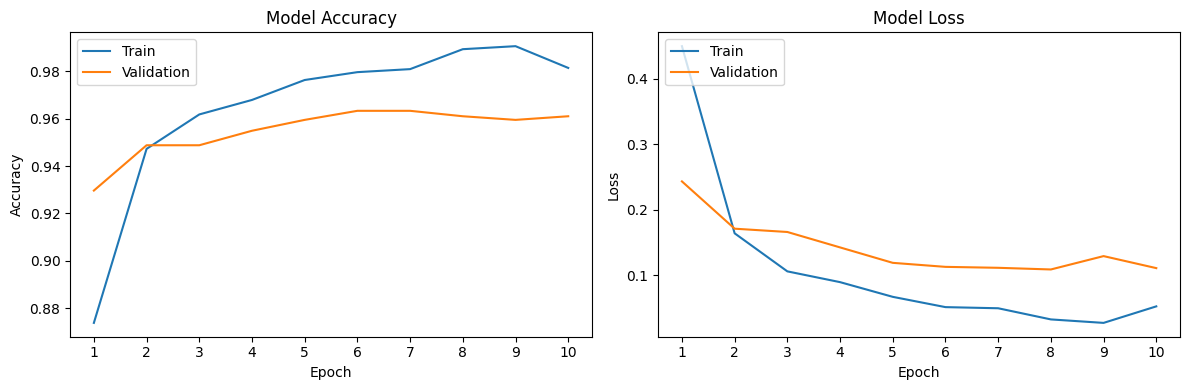


It took 8 minutes 15 seconds seconds to train the model.


In [ ]:
# Define the preprocessing function
def preprocess_image(image, label):
    image = applications.resnet.preprocess_input(image)
    return image, label

# Apply necessary preprocessing using tf.data.Dataset.map()
resnet_train = train_set.map(preprocess_image)
resnet_val = validation_set.map(preprocess_image)
resnet_test = test_set.map(preprocess_image)

# Train the model
fit_plot_store('ResNet50', resnet50)

Our accuracy is high at 96% for the validation set. We're also showing clear signs of overfitting.

I could tweak the CNN layers. However, since the accuracy is already very high, I'll just add another dense layer at the end and see if that helps.

## Second ResNet50 Model

In [ ]:
# Build a ResNes 50 model and evaluate it
resnet50_base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max',
    input_shape=(img_size[0], img_size[1], 3)

)

# Freeze the ResNet50 model
resnet50_base.trainable = False

# Add a dense layer
resnet50_2 = models.Sequential([
    resnet50_base,
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_2'
    )

# Compile the model
resnet50_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_9 (Dense)             (None, 8)                 16392     
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23604113 (90.04 MB)
Trainable params: 16401 (64.07 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/20
123/123 [==============================] - 55s 410ms/step - loss: 0.4853 - accuracy: 0.8741 - val_loss: 0.1957 - val_accuracy: 0.9419
Epoch 2/20
123/123 [==============================] - 41s 313ms/step - loss: 0.1459 - accuracy: 0.9467 - val_loss: 0.1359 - val_accuracy: 0.9457
Epoch 3/20
123/123 [==============================] - 43s 329ms/step - loss: 0.0934 - accuracy: 0.9605 - val_loss: 0.1242 - val_accuracy: 0.9641
Epoch 4/20
123/123 [==============================] - 40s 303ms/step - loss: 0.0874 - accuracy: 0.9623 - val_loss: 0.1268 - val_accuracy: 0.9641
Epoch 5/20
123/123 [==============================] - 42s 310ms/step - loss: 0.0611 - accuracy: 0.9766 - val_loss: 0.1213 - val_accuracy: 0.9656
Epoch 6/20
123/123 [==============================] - 42s 329ms/step - loss: 0.0515 - accuracy: 0.9794 - val_loss: 0.0830 - val_accuracy: 0.9709
Epoch 7/20
123/123 [==============================] - 44s 330ms/step - loss: 0.0404 - accuracy: 0.9847 - val_loss: 0.1303 - val_ac

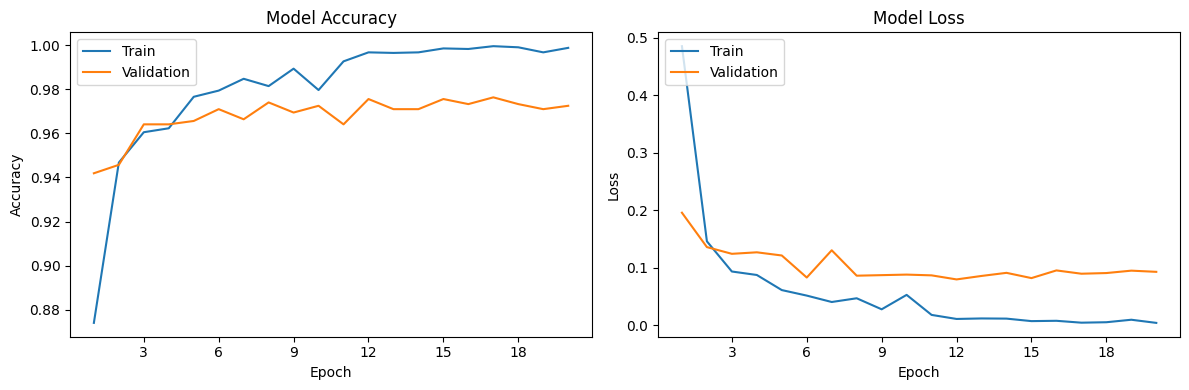


It took 17 minutes 17 seconds seconds to train the model.


In [ ]:
fit_plot_store('ResNet50_2', resnet50_2, epochs=20)


Definitely overfitting! Though our `EarlyStopping` callback caught this and stopped the training. The model's been reverted back to it's best epoch, which had an accuracy of 97.6%.

## Third ResNet50 Model

Since our last model was overfitting, it's unlikely that increasing complexity will help. However, for demostration, let's try adding another dense layer.

In [ ]:
# Add a dense layer
resnet50_3 = models.Sequential([
    resnet50_base,
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_2'
    )

# Compile the model
resnet50_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_11 (Dense)            (None, 16)                32784     
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23620641 (90.11 MB)
Trainable params: 32929 (128.63 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/10
123/123 [==============================] - 45s 326ms/step - loss: 0.3990 - accuracy: 0.8076 - val_loss: 0.2602 - val_accuracy: 0.9075
Epoch 2/10
123/123 [==============================] - 42s 332ms/step - loss: 0.2352 - accuracy: 0.9368 - val_loss: 0.2350 - val_accuracy: 0.9427
Epoch 3/10
123/123 [==============================] - 40s 310ms/step - loss: 0.2103 - accuracy: 0.9546 - val_loss: 0.2217 - val_accuracy: 0.9381
Epoch 4/10
123/123 [==============================] - 39s 304ms/step - loss: 0.1887 - accuracy: 0.9625 - val_loss: 0.1926 - val_accuracy: 0.9580
Epoch 5/10
123/123 [==============================] - 40s 313ms/step - loss: 0.1608 - accuracy: 0.9730 - val_loss: 0.2230 - val_accuracy: 0.9580
Epoch 6/10
123/123 [==============================] - 39s 301ms/step - loss: 0.1519 - accuracy: 0.9743 - val_loss: 0.1706 - val_accuracy: 0.9587
Epoch 7/10
123/123 [==============================] - 40s 301ms/step - loss: 0.1377 - accuracy: 0.9781 - val_loss: 0.1984 - val_ac

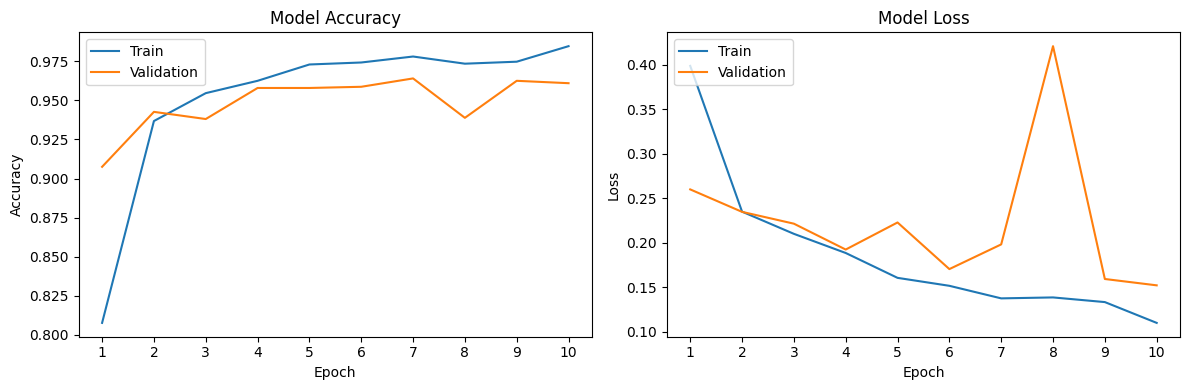


It took 6 minutes 50 seconds seconds to train the model.


In [ ]:
fit_plot_store('ResNet50_3', resnet50_3)

# Displaying Results

In [ ]:
column_names = ['Model Name', 'Training Accuracy', 'Validation Accuracy',
                'Training Loss', 'Validation Loss', 'Trainable Parameters',
                'Non-trainable Parameters', 'Total Parameters',
                'Number of Epochs', 'Time to Run']


# Changes the list to a DataFrame
model_info_df = pd.DataFrame(model_info, columns=column_names)
model_info_df.set_index('Model Name', inplace=True)

# Sort the DataFrame by Model Name
model_info_df.sort_values('Model Name', inplace=True)
model_info_df

,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Trainable Parameters,Non-trainable Parameters,Total Parameters,Number of Epochs,Time to Run
Model Name,,,,,,,,,
Model 1,0.739806,0.749235,0.600224,0.590905,1048817,0.0,1048817.0,6,221.063831
Model 2,0.987003,0.958716,0.108460,0.163444,263769,0.0,263769.0,10,382.969897
Model 3,0.739806,0.749235,0.600366,0.591087,263769,0.0,263769.0,6,225.046910
Model 4,0.930173,0.924312,0.203995,0.208819,556993,0.0,556993.0,17,692.594267
ResNet50,0.981397,0.961009,0.052167,0.110561,2049,23587712.0,23589761.0,10,495.289877
ResNet50_2,0.998726,0.972477,0.004081,0.092865,16401,23587712.0,23604113.0,20,1036.724360
ResNet50_3,0.984710,0.961009,0.110194,0.152387,32929,23587712.0,23620641.0,10,409.843084


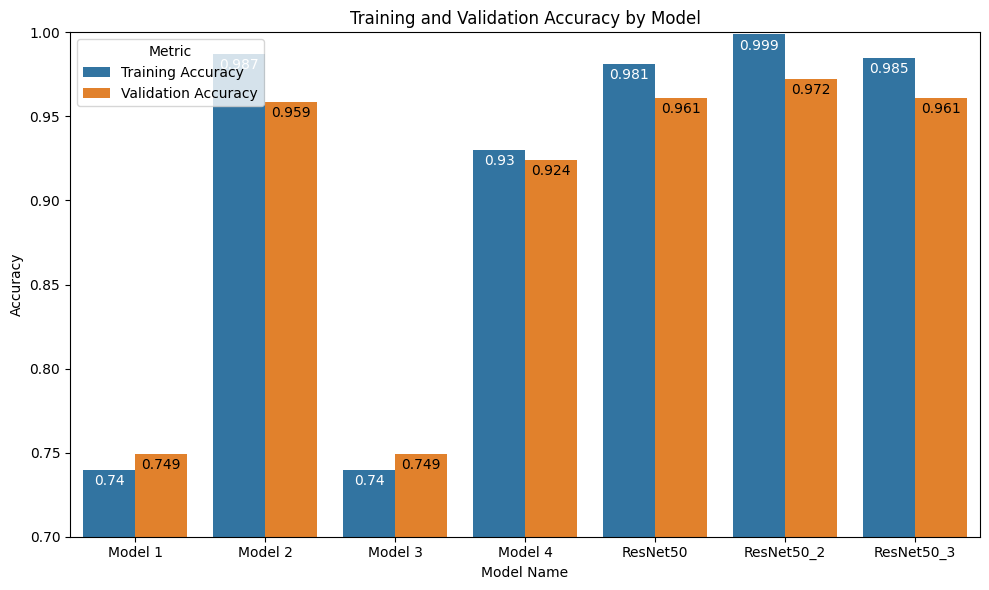

In [ ]:
def plot_training_validation_accuracy(df, subtitle=''):
    ''' Plots the training and validation accuracy for each model in df '''
    # Reshape the data from wide to long format
    melted_df = df.reset_index().melt(id_vars='Model Name',
                                      value_vars=['Training Accuracy', 'Validation Accuracy'],
                                      var_name='Metric',
                                      value_name='Accuracy')

    # Plot the vertical bar chart using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model Name', y='Accuracy', hue='Metric', data=melted_df)

    # Set the title and axis labels
    plt.title('Training and Validation Accuracy by Model' + subtitle)
    plt.xlabel('Model Name')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, 1)
    plt.tight_layout()

    # Add value labels to the bars
    ax.bar_label(ax.containers[0], fmt='%.3g', label_type='edge', padding=-13, color='white')
    ax.bar_label(ax.containers[1], fmt='%.3g', label_type='edge', padding=-13, color='black')

    # Display the plot
    plt.show()

plot_training_validation_accuracy(model_info_df)

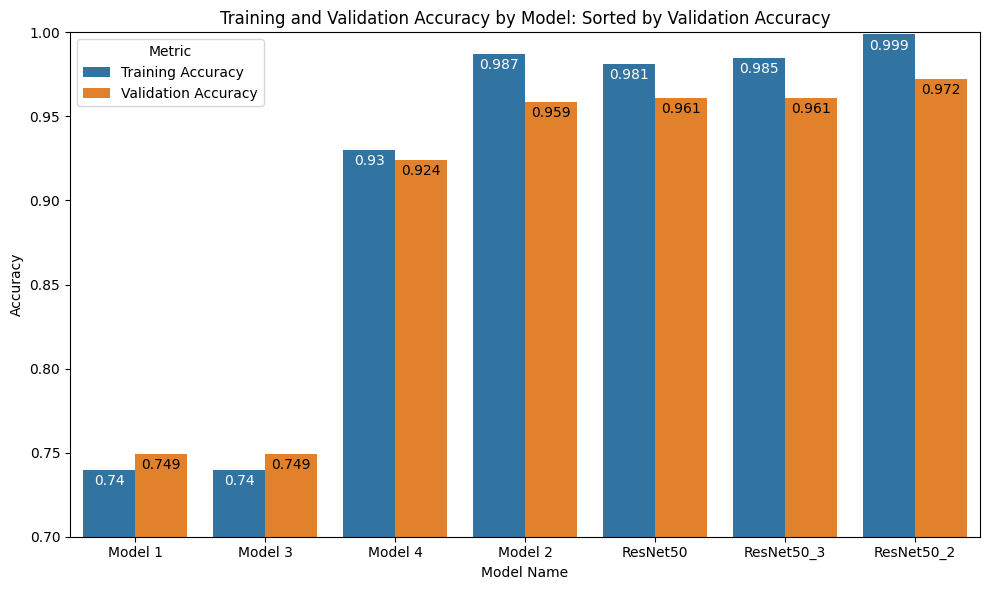

In [ ]:
# Sort the DataFrame by validation accuracy
by_val = model_info_df.sort_values('Validation Accuracy')
plot_training_validation_accuracy(by_val, subtitle=': Sorted by Validation Accuracy')

# Run the best two models on the test set


In [ ]:
for model in model_list:
    # Evaluate the model on the test set
      test_loss, test_accuracy = model.evaluate(test_set)

      # Print test accuracy
      print(f'Test Accuracy for {model} is: {test_accuracy}')